In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/machine/object_detection_in.h5
/kaggle/input/machine/object_detection_inception4.h5
/kaggle/input/car-plate-detection/annotations/Cars339.xml
/kaggle/input/car-plate-detection/annotations/Cars13.xml
/kaggle/input/car-plate-detection/annotations/Cars74.xml
/kaggle/input/car-plate-detection/annotations/Cars16.xml
/kaggle/input/car-plate-detection/annotations/Cars291.xml
/kaggle/input/car-plate-detection/annotations/Cars236.xml
/kaggle/input/car-plate-detection/annotations/Cars429.xml
/kaggle/input/car-plate-detection/annotations/Cars132.xml
/kaggle/input/car-plate-detection/annotations/Cars251.xml
/kaggle/input/car-plate-detection/annotations/Cars51.xml
/kaggle/input/car-plate-detection/annotations/Cars165.xml
/kaggle/input/car-plate-detection/annotations/Cars313.xml
/kaggle/input/car-plate-detection/annotations/Cars240.xml
/kaggle/input/car-plate-detection/annotations/Cars201.xml
/kaggle/input/car-plate-detection/annotations/Cars412.xml
/kaggle/input/car-plate-detection/an

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [7]:
path = glob('../input/car-plate-detection/annotations/*.xml')
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)

    labels_dict['filepath'].append(filename)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)

In [8]:
df = pd.DataFrame(labels_dict)
df.to_csv('labels.csv',index=False)
df.head()

,filepath,xmin,xmax,ymin,ymax
0,../input/car-plate-detection/annotations/Cars3...,209,283,135,169
1,../input/car-plate-detection/annotations/Cars1...,191,242,147,169
2,../input/car-plate-detection/annotations/Cars7...,115,277,115,153
3,../input/car-plate-detection/annotations/Cars1...,36,62,175,186
4,../input/car-plate-detection/annotations/Cars2...,71,215,205,246


In [9]:
filename = df['filepath'][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find('filename').text
    filepath_image = os.path.join('../input/car-plate-detection/images',filename_image)
    return filepath_image
getFilename(filename)

'../input/car-plate-detection/images/Cars339.png'

In [10]:
image_path = list(df['filepath'].apply(getFilename))
image_path[:10]#random check

['../input/car-plate-detection/images/Cars339.png',
 '../input/car-plate-detection/images/Cars13.png',
 '../input/car-plate-detection/images/Cars74.png',
 '../input/car-plate-detection/images/Cars16.png',
 '../input/car-plate-detection/images/Cars291.png',
 '../input/car-plate-detection/images/Cars236.png',
 '../input/car-plate-detection/images/Cars429.png',
 '../input/car-plate-detection/images/Cars132.png',
 '../input/car-plate-detection/images/Cars251.png',
 '../input/car-plate-detection/images/Cars51.png']


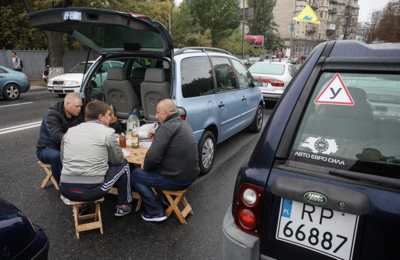

In [11]:
rand = np.random.randint(1,430)
file_path = image_path[rand] #path of our image N2.jpeg
img = cv2.imread(file_path) #read the image
# xmin-1804/ymin-1734/xmax-2493/ymax-1882 
img = io.imread(file_path) #Read the image
fig = px.imshow(img)
fig.update_layout(width=500, height=375, margin=dict(l=10, r=10, b=10, t=10),xaxis_title='Figure 8 - N2.jpeg with bounding box')
fig.add_shape(type='rect',x0=df.loc[rand,'xmin'], x1=df.loc[rand,'xmax'], y0=df.loc[rand,'ymin'], y1=df.loc[rand,'ymax'], xref='x', yref='y',line_color='cyan')

In [12]:
#Targeting all our values in array selecting all columns
labels = df.iloc[:,1:].values
data = []
output = []
for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    # Prepprocesing
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    norm_load_image_arr = load_image_arr/255.0 # Normalization
    # Normalization to labels
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax) # Normalized output
    # Append
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [13]:
# Convert data to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [14]:
# Split the data into training and testing set using sklearn.
x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((346, 224, 224, 3), (87, 224, 224, 3), (346, 4), (87, 4))

### Building the model

In [19]:
import tensorflow as tf 
from tensorflow.keras.layers import Activation, Conv2D , AvgPool2D,BatchNormalization,Dropout,Flatten,concatenate,Input,MaxPool2D,Dense

from tensorflow.keras.models import Model

In [83]:
### conv block
def conv_block (X,filters,kernel_size,padding="same",strides=(1,1),use_bias = False):
    X = Conv2D(filters =filters,kernel_size = kernel_size,padding=padding,strides =strides,use_bias=use_bias)(X)
    X = BatchNormalization(axis =-1,momentum = 0.9997, scale = False)(X)
    X = Activation('relu')(X)
    return X

In [84]:
### steam
def steam(X):
    X = conv_block(X,filters=32,kernel_size=(3,3),strides=2,padding='valid')
    X = conv_block(X,filters=32,kernel_size=(3,3),padding='valid')
    X = conv_block(X,filters=64,kernel_size=(3,3))
    
    
    X1= conv_block(X,filters=96,kernel_size=(3,3),strides=2,padding='valid')
    X = MaxPool2D(padding ='valid',strides=2,pool_size =(3,3))(X)
    X = concatenate([X1,X],axis = -1)
    X1 =conv_block(X,filters=64,kernel_size=(1,1))
    X1 =conv_block(X1,filters=96,kernel_size=(3,3),padding ='valid')
    X =conv_block(X,filters=64,kernel_size=(1,1))
    X = conv_block(X,filters=64,kernel_size=(7,1))
    X = conv_block(X,filters=64,kernel_size=(1,7))
    X = conv_block(X,filters=96,kernel_size=(3,3),padding='valid')
    X = concatenate([X1,X],axis =-1)
    X1 = conv_block(X,filters=192,kernel_size=(3,3),strides =2,padding='valid')
    X2 = MaxPool2D((3,3),strides =2,padding ='valid')(X)
    X = concatenate([X1,X2],axis = -1)
    return  X


In [85]:
def inception_A(input):
    inc_1 =AvgPool2D((3,3),strides=1,padding= 'same')(input)
    inc_1 =conv_block(inc_1,filters=96,kernel_size=(1,1))
    inc_2 =conv_block(input,filters=96,kernel_size=(1,1))
    inc_3 =conv_block(input,filters=64,kernel_size=(1,1))
    inc_3 =conv_block(inc_3,filters=96,kernel_size=(3,3))
    inc_4 =conv_block(input,filters=64,kernel_size=(1,1))
    inc_4 = conv_block(inc_4,filters=96,kernel_size=(3,3))
    inc_4 = conv_block(inc_4,filters=96,kernel_size=(3,3))
    output = concatenate([inc_1,inc_2,inc_3,inc_4],axis =-1)
    return output

In [86]:
def inception_B(input):
    inc_1 = AvgPool2D((3,3),strides=1,padding= "same")(input)
    inc_1 =conv_block(inc_1,filters=128,kernel_size=(1,1))
    inc_2 = conv_block(input,filters=384,kernel_size=(1,1))
    inc_3 =conv_block(input,filters=192,kernel_size=(1,1))
    inc_3 = conv_block(inc_3,filters=224,kernel_size=(7,1))
    inc_3 =conv_block(inc_3,filters=256,kernel_size=(1,7))
    inc_4 = conv_block(input,filters=192,kernel_size=(1,1))
    inc_4 = conv_block(inc_4,filters=192,kernel_size=(1,7))
    inc_4 = conv_block(inc_4,filters=224,kernel_size=(7,1))
    inc_4 = conv_block(inc_4,filters=224,kernel_size=(1,7))
    inc_4 = conv_block(inc_4,filters=256,kernel_size=(7,1))
    output = concatenate([inc_1,inc_2,inc_3,inc_4],axis =-1)
    return output
    
    

In [87]:
def inception_C(input):
    inc_1 = AvgPool2D((3,3),strides=1,padding= 'same')(input)
    inc_1 =conv_block(inc_1,filters=256,kernel_size=(1,1))
    inc_2 =conv_block(input,filters=256,kernel_size=(1,1))
    inc_3 =conv_block(input,filters=384,kernel_size=(1,1))
    inc_3_1 =conv_block(inc_3,filters=256,kernel_size=(1,3))
    inc_3_2 = conv_block(inc_3,filters=256,kernel_size=(3,1))
    inc_4 = conv_block(input,filters=384,kernel_size=(1,1))
    inc_4 = conv_block(inc_4,filters=448,kernel_size=(1,3))
    inc_4 = conv_block(inc_4,filters=512,kernel_size=(3,1))
    inc_4_1 = conv_block(inc_4,filters=256,kernel_size=(3,1))
    inc_4_2 =conv_block(inc_4,filters=256,kernel_size=(1,3))
    output = concatenate([inc_1,inc_2,inc_3_1,inc_3_2,inc_4_1,inc_4_2],axis =-1)
    return output

In [88]:
def reduction_A(input, k = 192, l = 224, m = 256, n = 384):
    red_1 = MaxPool2D((3,3),padding ='valid',strides =2)(input)
    red_2 = conv_block(input,filters=n,kernel_size=(3,3),strides=2,padding ='valid')
    red_3 = conv_block(input,filters=k,kernel_size=(1,1))
    red_3 =conv_block(red_3,filters=l,kernel_size=(3,3))
    red_3 =conv_block(red_3,filters=m,kernel_size=(3,3),padding= 'valid',strides=2)
    output = concatenate([red_1,red_2,red_3],axis =-1)
    return output

In [89]:
def reduction_B(input):
    red_1 = MaxPool2D((3,3),padding ='valid',strides =2)(input)
    red_2 =conv_block(input,filters=192,kernel_size=(1,1))
    red_2 = conv_block(red_2,filters=192,kernel_size=(3,3),padding = 'valid',strides=2)
    red_3 = conv_block(input,filters=256,kernel_size=(1,1))
    red_3 =conv_block(red_3,filters=256,kernel_size=(1,7))
    red_3 =conv_block(red_3,filters=320,kernel_size=(7,1))
    red_3 =conv_block(input,filters=320,kernel_size=(3,3),padding ='valid',strides =2)
    output = concatenate([red_1,red_2,red_3],axis =-1)
    return output


![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-12_at_1.03.34_PM_s0XaBC1.png)

In [90]:
def inception_v4(nb_classes = 1001, load_weights = True):
    init = Input((299, 299, 3))
    X =steam(init)
    for i in range(4):
        X = inception_A(X)
    X = reduction_A(X)
    for i in range(7):
        X = inception_B(X)
    X = reduction_B(X)
    for i in range(3):
        X = inception_C(X)
    
    X = AvgPool2D((8, 8))(X)

    
    X= Dropout(0.2)(X) 
    X = Flatten()(X) 

    
    output = Dense(units = nb_classes, activation = "softmax")(X) 

    model = Model(init, output, name = "Inception-v4")   
        
    return model
    
        

In [91]:
model = inception_v4(nb_classes = 4)


In [92]:
# Complie model

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "Inception-v4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_812 (Conv2D)            (None, 149, 149, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_812 (Batch  (None, 149, 149, 32  96         ['conv2d_812[0][0]']             
 Normalization)                 )                                                      

In [93]:

history = model.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test))

Epoch 1/50


2023-05-03 21:08:56.153605: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inInception-v4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


35/35 [==============================] - 62s 334ms/step - loss: 0.1436 - val_loss: 0.1485
Epoch 2/50
35/35 [==============================] - 8s 237ms/step - loss: 0.1346 - val_loss: 0.1479
Epoch 3/50
35/35 [==============================] - 8s 236ms/step - loss: 0.1314 - val_loss: 0.1478
Epoch 4/50
35/35 [==============================] - 8s 236ms/step - loss: 0.1302 - val_loss: 0.1474
Epoch 5/50
35/35 [==============================] - 8s 236ms/step - loss: 0.1287 - val_loss: 0.1469
Epoch 6/50
35/35 [==============================] - 8s 238ms/step - loss: 0.1281 - val_loss: 0.1468
Epoch 7/50
35/35 [==============================] - 8s 238ms/step - loss: 0.1277 - val_loss: 0.1465
Epoch 8/50
35/35 [==============================] - 8s 238ms/step - loss: 0.1256 - val_loss: 0.1461
Epoch 9/50
35/35 [==============================] - 8s 237ms/step - loss: 0.1255 - val_loss: 0.1456
Epoch 10/50
35/35 [==============================] - 8s 241ms/step - loss: 0.1259 - val_loss: 0.1454
Epoch 11/

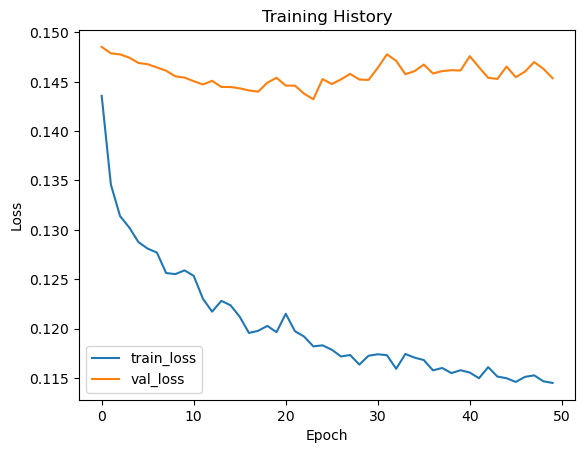

In [95]:
import matplotlib.pyplot as plt
# Plot the training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### ###################################################################################################################################################

In [16]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)

headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model2 = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 [==============================] - 1s 0us/step


In [17]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
# ---------------------
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)

headmodel = Dense(4,activation='sigmoid')(headmodel)


# ---------- model
model2 = Model(inputs=inception_resnet.input,outputs=headmodel)

![](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-06-12_at_1.24.15_PM_qDb6V3G.png)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_609 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_609 (Batch  (None, 111, 111, 32  96         ['conv2d_609[0][0]']             
 Normalization)                 )                                                           

In [23]:
# Complie model

model2.compile(loss='mse',optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4))
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [24]:

history = model2.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test))

Epoch 1/50
35/35 [==============================] - 61s 318ms/step - loss: 0.1030 - val_loss: 0.1457
Epoch 2/50
35/35 [==============================] - 6s 177ms/step - loss: 0.0872 - val_loss: 0.1121
Epoch 3/50
35/35 [==============================] - 6s 171ms/step - loss: 0.0741 - val_loss: 0.0905
Epoch 4/50
35/35 [==============================] - 6s 173ms/step - loss: 0.0623 - val_loss: 0.0799
Epoch 5/50
35/35 [==============================] - 6s 171ms/step - loss: 0.0585 - val_loss: 0.0769
Epoch 6/50
35/35 [==============================] - 6s 173ms/step - loss: 0.0516 - val_loss: 0.0727
Epoch 7/50
35/35 [==============================] - 6s 174ms/step - loss: 0.0479 - val_loss: 0.0689
Epoch 8/50
35/35 [==============================] - 6s 167ms/step - loss: 0.0469 - val_loss: 0.0651
Epoch 9/50
35/35 [==============================] - 6s 169ms/step - loss: 0.0446 - val_loss: 0.0609
Epoch 10/50
35/35 [==============================] - 6s 171ms/step - loss: 0.0431 - val_loss: 0.058

In [18]:
# Complie model


model2.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_203 (Conv2D)            (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_203 (Batch  (None, 111, 111, 32  96         ['conv2d_203[0][0]']             
 Normalization)                 )                                                           

In [19]:

history = model2.fit(x=x_train,y=y_train,batch_size=10,epochs=50,
                    validation_data=(x_test,y_test))

Epoch 1/50
35/35 [==============================] - 100s 311ms/step - loss: 0.0797 - val_loss: 0.0863
Epoch 2/50
35/35 [==============================] - 6s 180ms/step - loss: 0.0242 - val_loss: 0.0196
Epoch 3/50
35/35 [==============================] - 6s 174ms/step - loss: 0.0083 - val_loss: 0.0176
Epoch 4/50
35/35 [==============================] - 6s 185ms/step - loss: 0.0052 - val_loss: 0.0157
Epoch 5/50
35/35 [==============================] - 6s 173ms/step - loss: 0.0039 - val_loss: 0.0167
Epoch 6/50
35/35 [==============================] - 6s 173ms/step - loss: 0.0033 - val_loss: 0.0198
Epoch 7/50
35/35 [==============================] - 6s 179ms/step - loss: 0.0038 - val_loss: 0.0172
Epoch 8/50
35/35 [==============================] - 6s 173ms/step - loss: 0.0037 - val_loss: 0.0363
Epoch 9/50
35/35 [==============================] - 6s 183ms/step - loss: 0.0031 - val_loss: 0.0397
Epoch 10/50
35/35 [==============================] - 6s 173ms/step - loss: 0.0029 - val_loss: 0.02

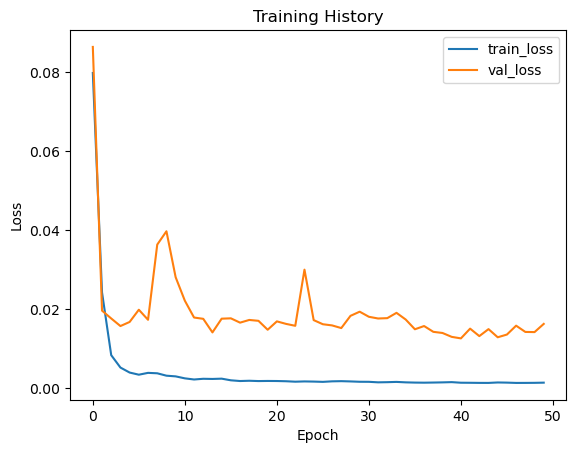

In [20]:
# Plot the training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

###  We will use the  in_res v2


In [21]:
path = "/kaggle/input/car-plate-detection/images/Cars101.png"
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # Convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print('Height of the image =',h)
print('Width of the image =',w)

Height of the image = 300
Width of the image = 400



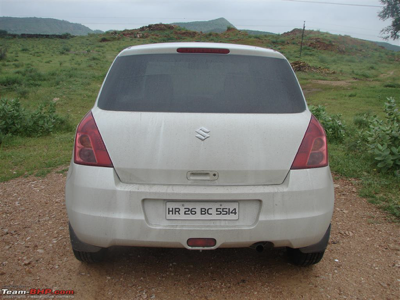

In [22]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title='Figure 13 - TEST Image')

In [72]:
image_arr_224.shape


(224, 224, 3)

In [73]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

In [74]:
# Make predictions
coords = model2.predict(test_arr)
coords

1/1 [==============================] - 0s 50ms/step


array([[0.4200885 , 0.5968525 , 0.67007923, 0.73055744]], dtype=float32)

In [75]:
# Denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[168.03539991, 238.74099255, 201.02376938, 219.16723251]])

In [76]:
coords = coords.astype(np.int32)
coords

array([[168, 238, 201, 219]], dtype=int32)

In [77]:
# Draw bounding on top the image

xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(168, 201) (238, 219)



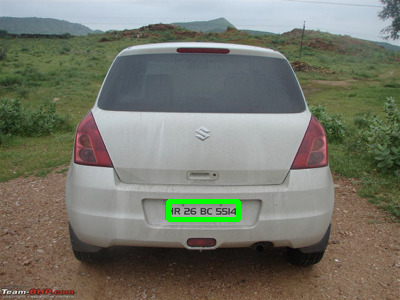

In [78]:
cv2.rectangle(image,pt1,pt2,(0,255,0),3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10))

(485, 421) (651, 487)
